# Building a Recommendation System Using CNN 
![](https://www.researchgate.net/profile/Andreas_Veit/publication/282181243/figure/fig1/AS:360995122892808@1463079352720/Visualization-of-a-2D-embedding-of-the-style-space-trained-with-strategic-sampling.png)



## Introduction

In this notebook, I will use a CNN Model to create a Fashion Embedding. This information can be used in ML algorithms with higher semantic quality and similarity between Objects. We will use embeddings to identify similar items, this information will be used to recommend similar content in RecSys.

* **Introduction**
    * What is Embedding ?
    * How to use Embedding ?
* **Data Preparation**
* **Use Pre-Trained Model to Recommendation**
* Visualization Latent Space of Contents

#### Configure VM

In [1]:
# !pip install swifter
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install opencv-python

## What is Embedding ?

An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

So a natural language modelling technique like Word Embedding is used to map words or phrases from a vocabulary to a corresponding vector of real numbers. As well as being amenable to processing by learning algorithms, this vector representation has two important and advantageous properties:

* **Dimensionality Reduction** — it is a more efficient representation
* **Contextual Similarity** — it is a more expressive representation

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSiR683wW4f9httU7krJeLcgDQRB3Fmxi4v2SIr8QLSht204cmk&s)

We can use the Embedding as input of the model, containing a reduced dimensionality but with much semantic information. 

## Data Preparation
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data.

In [2]:
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [3]:
DATASET_PATH = "./fashion-dataset/"
print(os.listdir(DATASET_PATH))

['fashion-dataset', 'images', 'images.csv', 'styles', 'styles.csv']


In [4]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

id gender masterCategory subCategory  articleType baseColour  season   
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall  \
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016  Casual                         Skagen Men Black Watch  30039.jpg

In [5]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1, default_folder=True):
    img     = cv2.imread(img_path(img)) if default_folder else cv2.imread(img)
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized


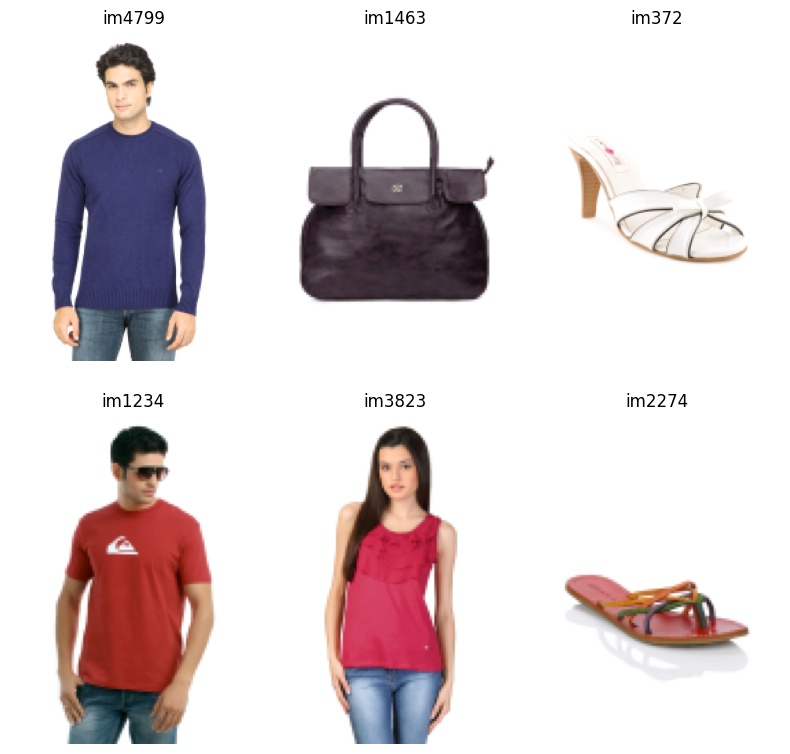

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

The Dataset is made up of different items that can be found in a marketplace. The idea is to use embeddings to search for similarity and find similar items just using the image.

<Axes: ylabel='articleType'>

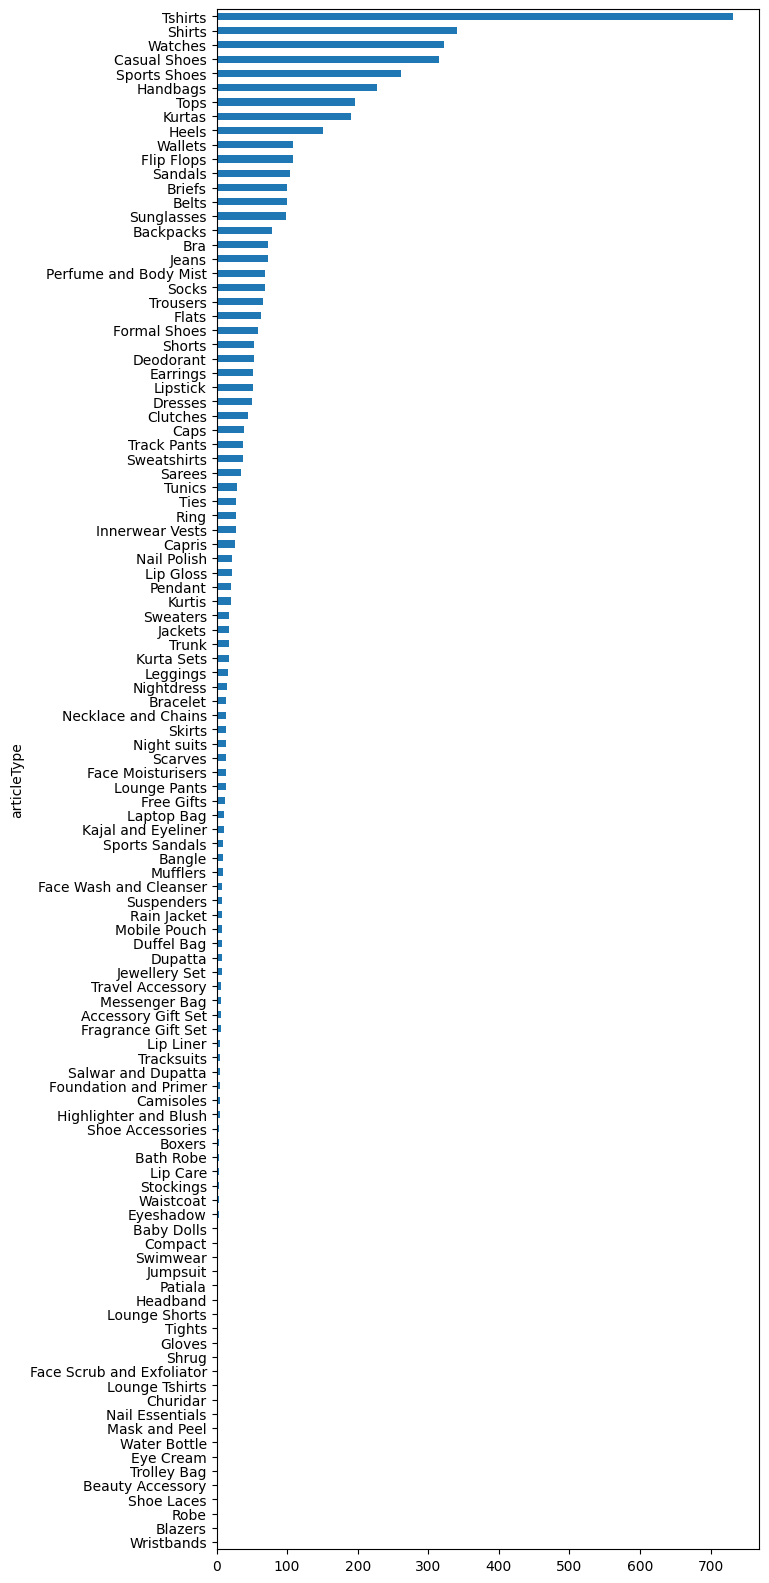

In [7]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

## Use Pre-Trained Model to Recommendation

In [8]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.14.0'

In [9]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [10]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

Get item Embedding

In [11]:
# emb = get_embedding(model, df.iloc[0].image)
# emb.shape

In [12]:
# img_array = load_image(df.iloc[0].image)
# plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
# print(img_array.shape)
# print(emb)

Get Embedding for all itens in dataset

In [13]:
%%time
#import swifter
import os
import pickle

# Parallel apply
df_embs = None

file_path = 'df_embs.pkl'

if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
        df_embs = pickle.load(file)
else:
    df_sample      = df#.sample(100)
    map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
    df_embs        = map_embeddings.apply(pd.Series)
    with open(file_path, 'wb') as file:
        pickle.dump(df_embs, file)

print(df_embs.shape)
df_embs.head()

(5000, 2048)
CPU times: total: 0 ns
Wall time: 306 ms


0          1         2          3         4         5          6      
0  5.939162   2.372262  0.000000   3.246115  0.957503  2.766369   8.802005  \
1  5.790416   9.593650  0.000000   9.431690  0.287235  0.259954  17.028755   
2  0.000000   3.162261  0.484694   0.172311  2.609542  3.840858   3.426129   
3  5.882206   1.958617  0.000000  12.519896  0.000000  0.000000   9.383582   
4  0.245958  17.383438  0.493822   3.374463  2.567364  0.000000   6.482537   

       7         8         9     ...       2038       2039       2040   
0  6.304132  0.805903  1.697347  ...   2.396972   0.000000   1.801747  \
1  3.037454  0.136341  0.000000  ...   1.670569   0.013894  10.338682   
2  0.253251  1.098898  1.418281  ...   0.434923  14.092843   3.018755   
3  3.781616  0.000000  1.490623  ...  17.825489   0.000000   3.592510   
4  5.862637  0.000000  3.164867  ...   4.464024   0.447082   1.448140   

        2041      2042      2043      2044      2045       2046       2047  
0  20.561768  3.954440  0.000000  8.289472  1.359558   0.000000  10.893187  
1   4.784732  0.189143  0.000000  7.739138  0.372702   0.000000   8.903797  
2   2.134512  2.549055  0.377388  6.180348  0.636619  14.018175  11.415056  
3   2.042311  0.000000  0.000000  6.656780  1.457315   1.694212   1.403330  
4  12.884133  0.000000  0.397491  5.028072  1.939694   0.000000  11.485395  

[5 rows x 2048 columns]

#### Compute Similarity Between Items

![](http://dataaspirant.com/wp-content/uploads/2015/04/cosine.png)

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999988 , 0.71280396, 0.45375025, 0.6793722 ],
       [0.71280396, 0.9999995 , 0.41515303, 0.83330876],
       [0.45375025, 0.41515303, 0.99999887, 0.44629467],
       [0.6793722 , 0.83330876, 0.44629467, 0.9999994 ]], dtype=float32)

In [15]:
df.iloc[2993]

id                                                   13849
gender                                                 Men
masterCategory                                     Apparel
subCategory                                        Topwear
articleType                                         Shirts
baseColour                                           White
season                                                Fall
year                                                  2011
usage                                               Casual
productDisplayName    Indigo Nation Men Check White Shirts
image                                            13849.jpg
Name: 2993, dtype: object

#### Recommender Similar Items

In [16]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    indices = pd.Series(range(len(df)), index=df.index)
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Index([251, 659, 2400, 0, 1821], dtype='int64'),
 [0.9244306, 0.92235076, 0.91876686, 0.9146251, 0.91380024])

In [18]:
def get_recommend_by_image(image_path):
    global df_embs
    df_embs = df_embs.drop(9999, errors='ignore')
    img = image.load_img(image_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    target_embing = model.predict(x).reshape(-1)
    target_embing.shape
    df_embs.loc[9999] = target_embing
    new_cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')

    indices = pd.Series(range(len(df_embs)), index=df_embs.index)
    sim_idx    = indices[9999]
    sim_scores = list(enumerate(new_cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    idx_rec, idx_sim = indices.iloc[idx_rec].index, idx_sim

    filtered_idx_rec = []
    filtered_idx_sim = []
    for i, x in enumerate(idx_rec):
        if x in df.index:
            filtered_idx_rec.append(x)
            filtered_idx_sim.append(idx_sim[i])
            
    filtered_idx_rec = filtered_idx_rec[:6]
    filtered_idx_sim = filtered_idx_sim[:6]

    figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[filtered_idx_rec].iterrows()}
    plt.imshow(cv2.cvtColor(load_image(image_path, default_folder=False), cv2.COLOR_BGR2RGB))
    plot_figures(figures, 2, 3)

1/1 [==============================] - 2s 2s/step


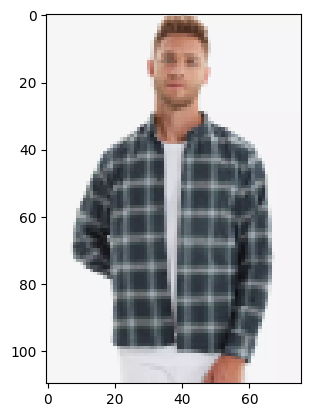

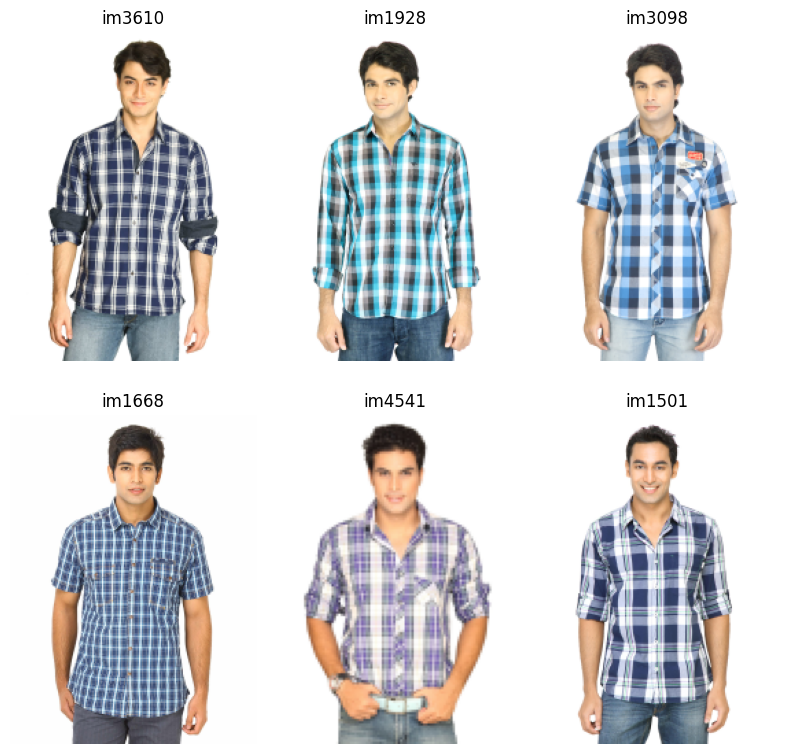

In [19]:
input_img_path = './1.webp'
get_recommend_by_image(input_img_path)

1/1 [==============================] - 0s 131ms/step


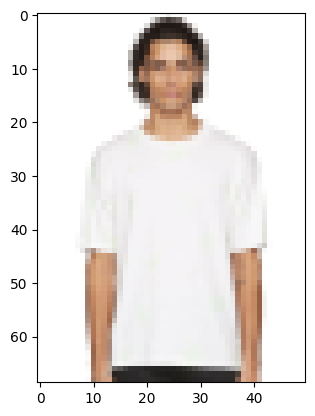

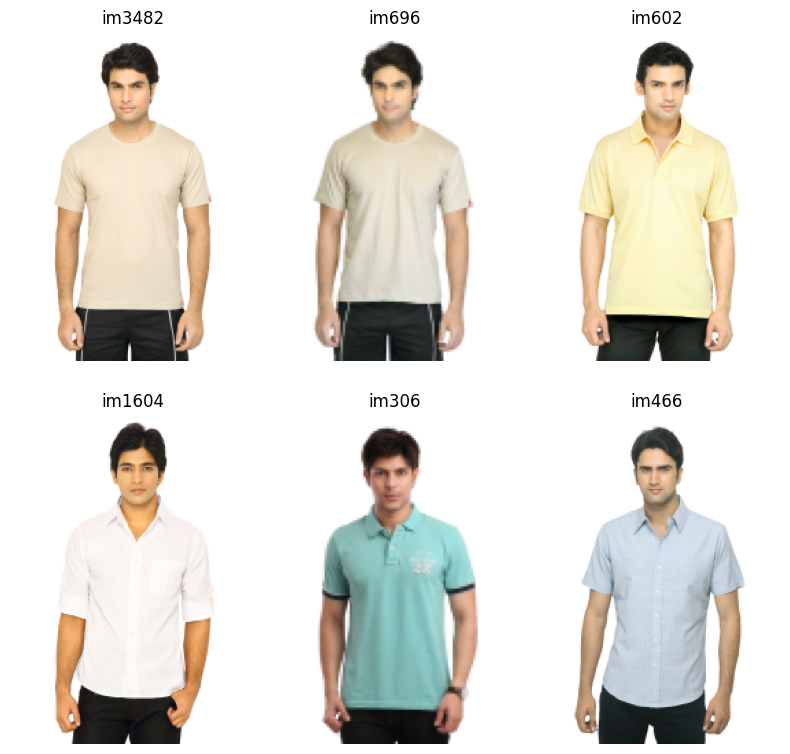

In [20]:
input_img_path = './2.jpg'
get_recommend_by_image(input_img_path)

1/1 [==============================] - 0s 126ms/step


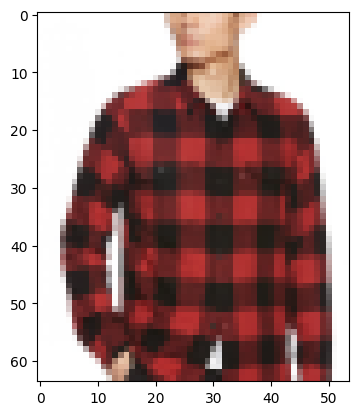

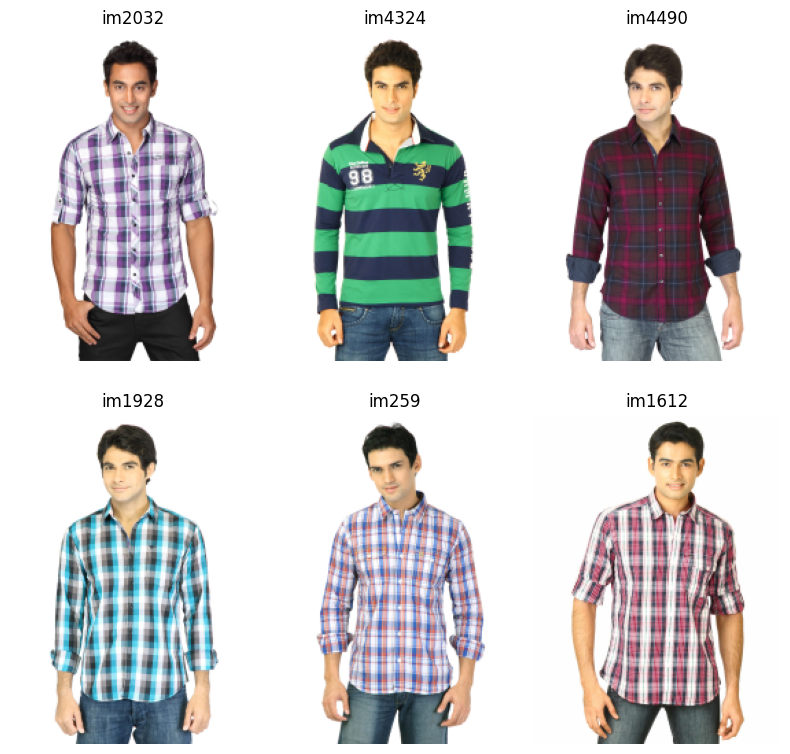

In [21]:
input_img_path = './3.jpg'
get_recommend_by_image(input_img_path)

# ------------------------------ END ------------------------------


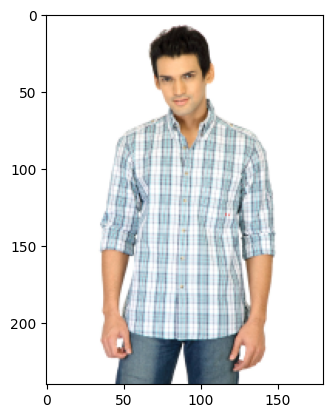

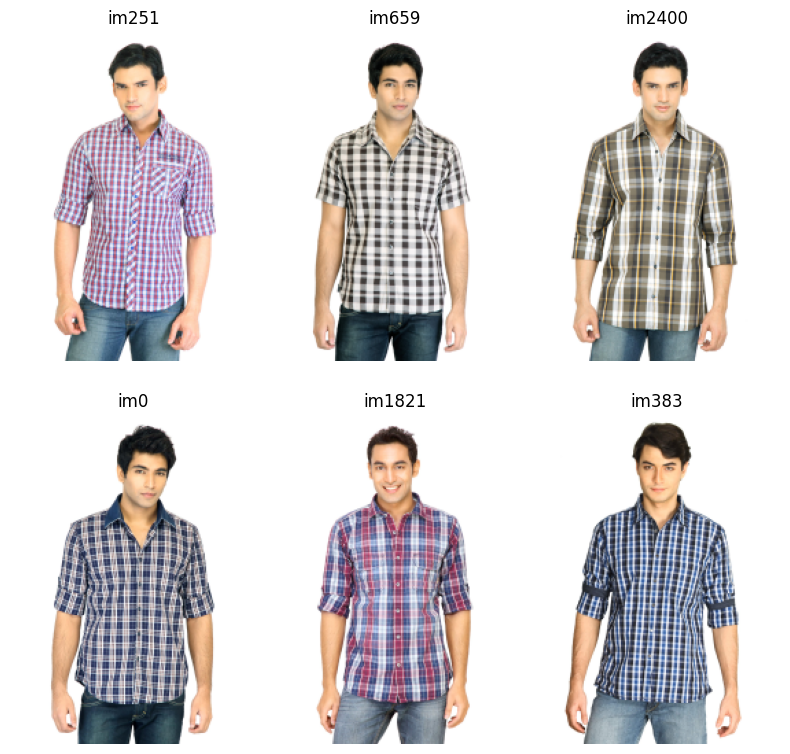

In [46]:
# Idx Item to Recommender
idx_ref = 1942

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

**Search for items similar to the reference to recommend. Apparently it's working!**

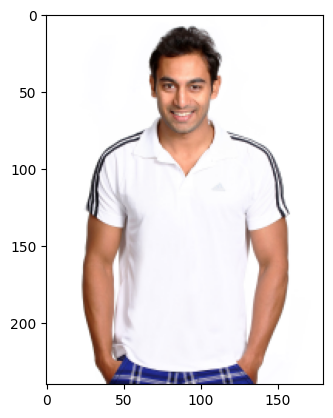

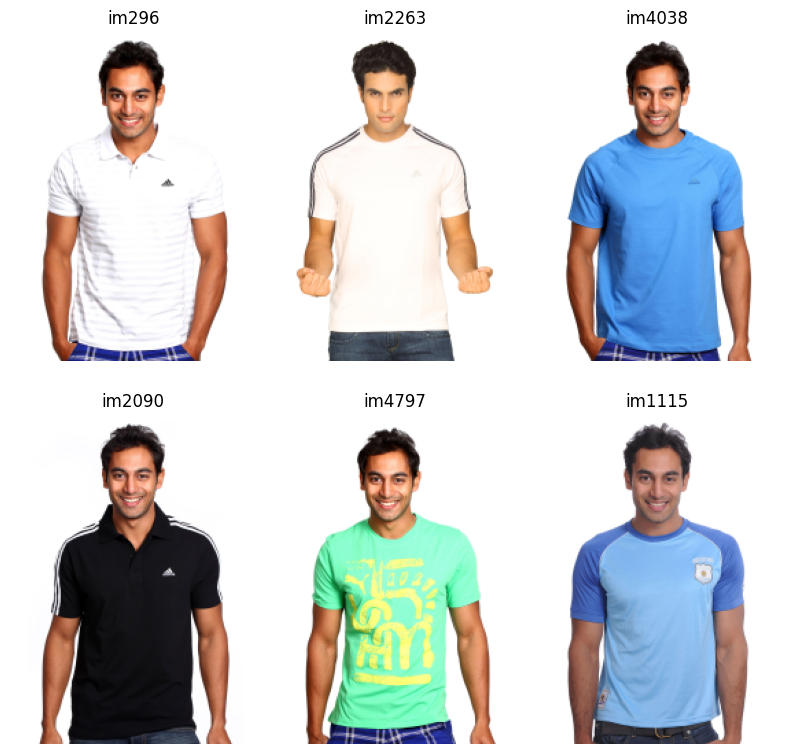

In [51]:
idx_ref = 4398

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [54]:
idx_ref = 4398

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)
idx_rec

Index([296, 2263, 4038, 2090, 4797, 1115], dtype='int64')

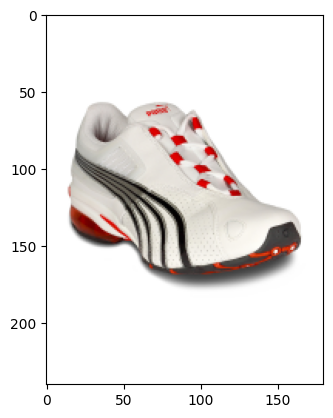

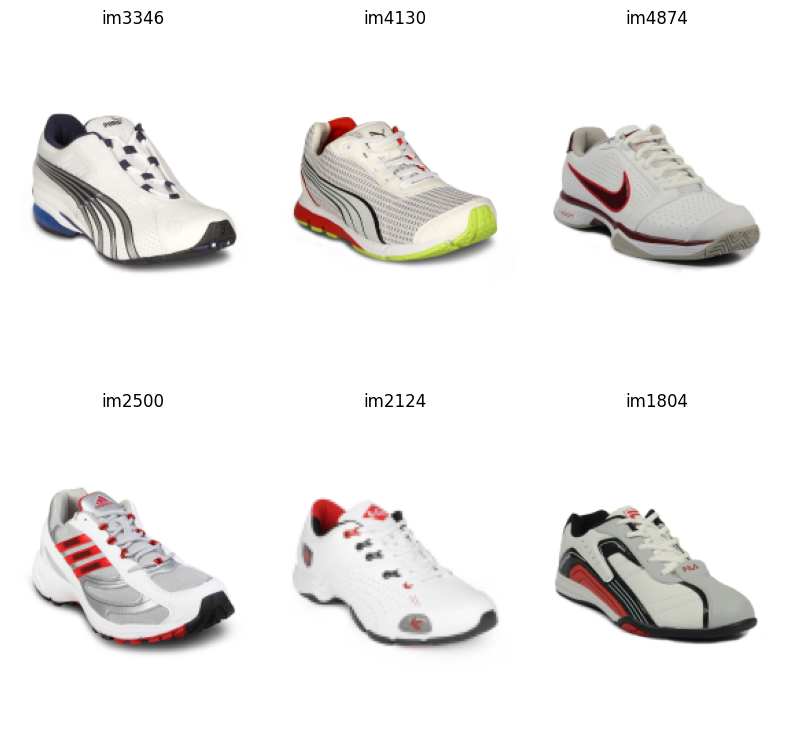

In [55]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

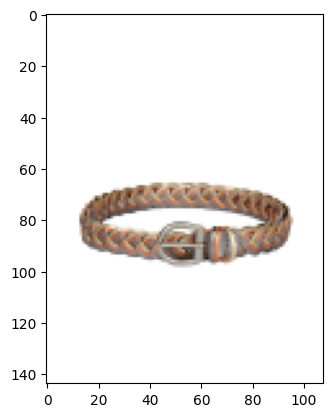

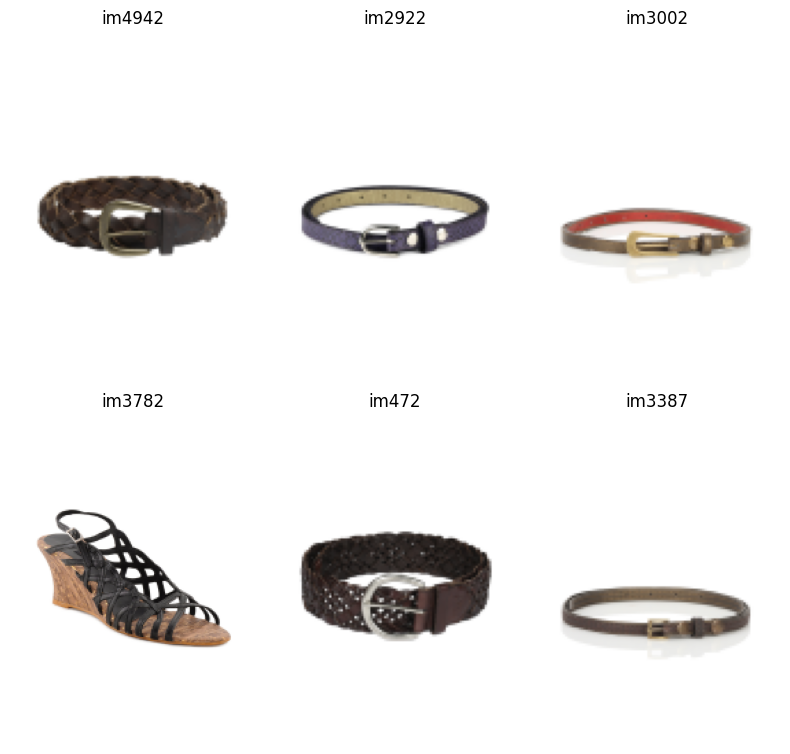

In [56]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

## Visualization Latent Space of Contents

Since our latent space is not two-dimensional, we will use TSNE to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane:

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
df.head()

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

You can see different clusters generated by embeddings, which reinforces that features make sense. In this image above it is possible to observe the separation by Category, and in more detail by subcategory.

Of course there is actually a lot more information in embeddings, the visualization is for general understanding only

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

## Conclusion

Convolutional networks can be used to generate generic embeddings of any content. These embeddings can be used to identify similar items and in a recommendation process.

A big improvement would be to retrain some network layers in a dataset similar to the one that will be used. So the network learns better features for a specific problem.

In [ ]:
df.sample(10).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')